<a href="https://colab.research.google.com/github/GUNAPILLCO/CEIA-GdP/blob/main/3_Desarrollo/2_obtencion_preparacion_exploracion_datos/2_4_2_hipotesis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.4.2. Hipótesis 2: Reversión a la Media (Mean Reversion)

## 1. Importación de Librerías

In [14]:
# Utilidades generales
from datetime import datetime, timedelta
import os
import glob
import requests
import warnings
warnings.filterwarnings('ignore')

# Manejo y procesamiento de datos
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
# Calendario de mercados
#import pandas_market_calendars as mcal

## 2. Carga del dataset mnq_intraday_data

In [2]:
def load_df():
    """
    Función para cargar un archivo Parquet desde una URL de GitHub, procesarlo y devolver un DataFrame.
    """
    # Definir la URL del archivo Parquet en GitHub
    url = 'https://raw.githubusercontent.com/GUNAPILLCO/CEIA-GdP/main/3_Desarrollo/2_obtencion_preparacion_exploracion_datos/mnq_intraday_data.parquet'

    # Descargar el archivo desde la URL
    response = requests.get(url)

    # Verificar si la descarga fue exitosa
    if response.status_code != 200:
        raise Exception(f"Error al descargar el archivo: {response.status_code}")

    # Guardar el archivo descargado en el entorno de Colab
    file_path = '/content/mnq_intraday_data.parquet'
    with open(file_path, 'wb') as f:
        f.write(response.content)

    # Leer el archivo Parquet y cargarlo en un DataFrame
    df = pd.read_parquet(file_path)

    # Asegurar que el índice esté en formato datetime
    df.index = pd.to_datetime(df.index)

    # Crear una nueva columna 'date' con la fecha extraída del índice
    df['date'] = df.index.date

    return df

In [3]:
mnq_intraday = load_df()

## 3. Hipótesis 2: Reversión a la Media (Mean Reversion)

**"Si el precio se aleja demasiado de su media móvil de corto plazo, tenderá a volver a ella."**
<br><br>
**Justificación técnica:**<br>
Alta frecuencia tiende a mostrar sobre-reacciones temporales. Este es un principio clásico del análisis técnico. En escalas de tiempo cortas, los precios tienden a oscilar alrededor de su media. Alejamientos extremos suelen generar correcciones rápidas, especialmente en activos líquidos como el MNQ.
<br><br>
**Alpha Factor sugerido:**

$$
\text{mean_reversion_factor}(t) = \frac{close(t) - \text{SMA}_N(t)}{\sigma_N(t)}
$$

Donde:
- $ \text{SMA}_N(t) $ es la media móvil simple de los últimos N minutos.
- ${\sigma_N(t)}$ es la desviación estándar en la misma ventana.

<br><br>
**El z-score te dice cuán lejos está un valor respecto a su promedio, medido en unidades de desviación estándar.**
Es una forma de medir si algo está “muy arriba” o “muy abajo” de lo normal.

## 4. Construcción de alpha factor

Usamos el z-score del precio respecto a su media móvil intradía. Cuanto más extremo el z-score, más probable la reversión.

In [11]:
# 1. Construir alpha factor (z-score del precio respecto a su media móvil y desviación estándar)
for N in [5, 15, 30]:
    sma_col = f'sma_{N}'
    std_col = f'std_{N}'
    z_col = f'zscore_{N}'

    # Media móvil y desviación estándar por jornada
    mnq_intraday[sma_col] = mnq_intraday.groupby('date')['close'].transform(
        lambda x: x.rolling(window=N, min_periods=1).mean()
    )
    mnq_intraday[std_col] = mnq_intraday.groupby('date')['close'].transform(
        lambda x: x.rolling(window=N, min_periods=1).std()
    )

    # Z-score intradía del precio
    mnq_intraday[z_col] = (mnq_intraday['close'] - mnq_intraday[sma_col]) / mnq_intraday[std_col]

# 2. Normalizar el factor por día (z-score del z-score)
'''Solo usar reversal_score_N si luego entrenás un modelo ML y querés asegurar una entrada perfectamente centrada y escalada por jornada.'''
# Esto lo vuelve comparable entre jornadas con diferentes volatibilidades
#for N in [5, 15, 30]:
#    z_col = f'zscore_{N}'
#    norm_col = f'reversal_score_{N}'  # alpha factor final

#    mnq_intraday[norm_col] = mnq_intraday.groupby('date')[z_col].transform(
#        lambda x: (x - x.mean()) / x.std()
#    )

# 3. Calcular los retornos futuros como variable objetivo
mnq_intraday['target_return_5'] = mnq_intraday.groupby('date')['close'].transform(
    lambda x: np.log(x.shift(-5)) - np.log(x)
)
mnq_intraday['target_return_15'] = mnq_intraday.groupby('date')['close'].transform(
    lambda x: np.log(x.shift(-15)) - np.log(x)
)
mnq_intraday['target_return_30'] = mnq_intraday.groupby('date')['close'].transform(
    lambda x: np.log(x.shift(-30)) - np.log(x)
)

# 4. Evaluar el poder predictivo del alpha factor (Information Coefficient por día)
ic_zscore_5 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['zscore_5'].corr(x['target_return_5'])
)
ic_zscore_15 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['zscore_15'].corr(x['target_return_15'])
)
ic_zscore_30 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['zscore_30'].corr(x['target_return_30'])
)

# 5. Mostrar resultados promedio
print(f"Mean IC (ZScore 5 min):  {ic_zscore_5.mean():.4f}")
print(f"Mean IC (ZScore 15 min): {ic_zscore_15.mean():.4f}")
print(f"Mean IC (ZScore 30 min): {ic_zscore_30.mean():.4f}")



Mean IC (ZScore 5 min):  -0.0212
Mean IC (ZScore 15 min): -0.0454
Mean IC (ZScore 30 min): -0.0769


1. La hipótesis original se valida.

  - El Information Coefficient (IC) entre el zscore_N y los retornos futuros es negativo y creciente con el horizonte:

    - 0.0212 a 5 minutos → débil pero consistente
    - 0.0454 a 15 minutos → más marcado
    - 0.0769 a 30 minutos → claro efecto de reversión

    Esto significa que el factor tiene valor predictivo en contra de la dirección del desvío del precio.


Como el z-score es un indicador de "desviación extrema", su efecto debería ser más marcado cuando su valor absoluto es grande.

## 5. Comportamiento del alpha factor por minutos del día

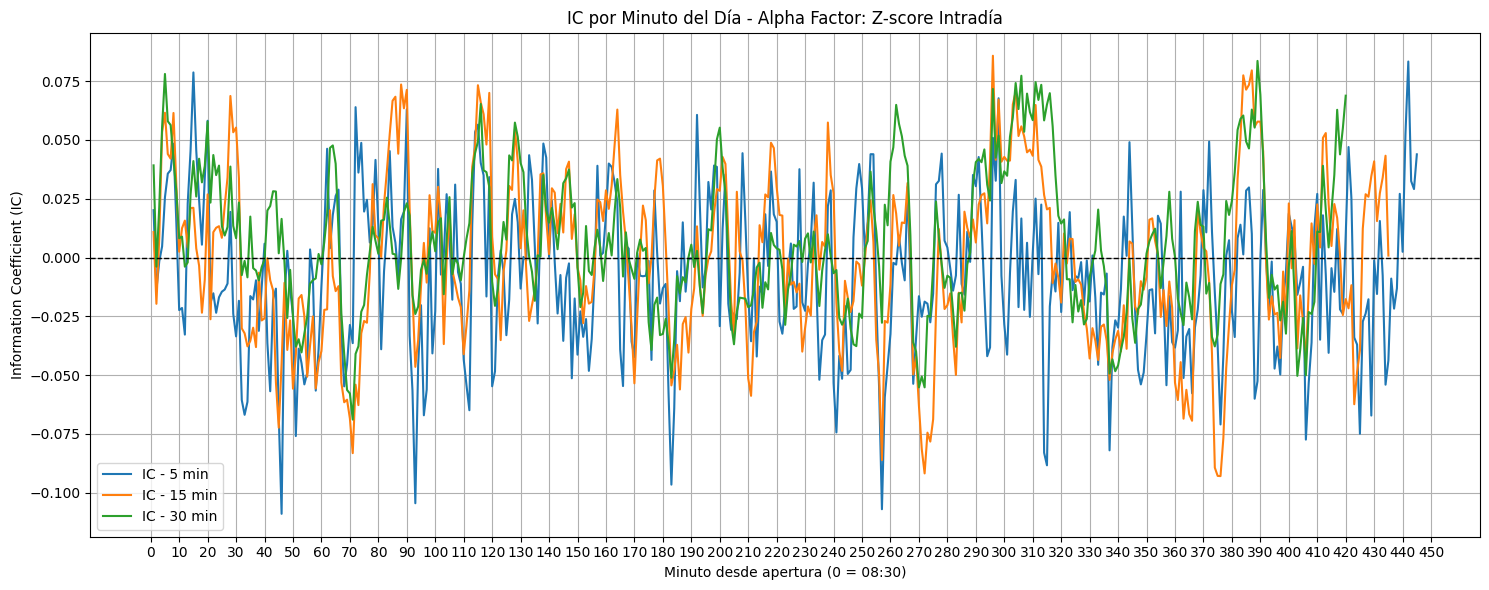

In [15]:
import pandas as pd
import numpy as np


# Asegurarse de tener un identificador de fila por jornada (0 a 450)
mnq_intraday['minute_index'] = mnq_intraday.groupby('date').cumcount()

# Función para calcular IC por minuto
def compute_ic_by_minute(factor_col, target_col):
    grouped = mnq_intraday[[factor_col, target_col, 'minute_index']].dropna()
    ic_by_minute = grouped.groupby('minute_index').apply(
        lambda x: x[factor_col].corr(x[target_col])
    )
    return ic_by_minute

# Calcular IC por minuto para cada ventana temporal
ic_minute_5 = compute_ic_by_minute('zscore_5', 'target_return_5')
ic_minute_15 = compute_ic_by_minute('zscore_15', 'target_return_15')
ic_minute_30 = compute_ic_by_minute('zscore_30', 'target_return_30')


# Visualización
plt.figure(figsize=(15, 6))
plt.xticks(np.arange(0, 451, 10))
plt.plot(ic_minute_5.index, ic_minute_5, label='IC - 5 min')
plt.plot(ic_minute_15.index, ic_minute_15, label='IC - 15 min')
plt.plot(ic_minute_30.index, ic_minute_30, label='IC - 30 min')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('IC por Minuto del Día - Alpha Factor: Z-score Intradía')
plt.xlabel('Minuto desde apertura (0 = 08:30)')
plt.ylabel('Information Coefficient (IC)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
def analyze_intraday_ic_extremes(ic_minute_df: pd.DataFrame) -> pd.DataFrame:
    """
    Analiza series de Information Coefficient (IC) minuto a minuto para distintos alpha factors.
    Retorna un resumen con el peor IC, el minuto donde ocurre y el promedio de los 30 peores ICs.

    Parámetros:
    - ic_minute_df: DataFrame con columnas = alpha factors, índice = minuto (0 a 450)

    Retorna:
    - DataFrame resumen ordenado por el promedio de los 30 peores ICs
    """
    results = []

    for col in ic_minute_df.columns:
        series = ic_minute_df[col].dropna()
        min_ic = series.min()
        min_minute = series.idxmin()
        mean_worst_30 = series.nsmallest(30).mean()

        results.append({
            'Alpha Factor': col,
            'IC mínimo': min_ic,
            'Minuto del IC mínimo': min_minute,
            'Promedio de los 30 peores ICs': mean_worst_30
        })

    result_df = pd.DataFrame(results).set_index('Alpha Factor')
    result_df = result_df.sort_values('Promedio de los 30 peores ICs')
    return result_df

In [18]:
# Suponiendo que ya tenés ic_minute_5, ic_minute_15, ic_minute_30
ic_minute_df = pd.DataFrame({
    'IC_zcore_5': ic_minute_5,
    'IC_zcore_15': ic_minute_15,
    'IC_zcore_30': ic_minute_30
})

analyze_intraday_ic_extremes(ic_minute_df)

,IC mínimo,Minuto del IC mínimo,Promedio de los 30 peores ICs
Alpha Factor,,,
IC_zcore_5,-0.108979,46,-0.071159
IC_zcores_15,-0.092939,376,-0.069216
IC_zcore_30,-0.068905,71,-0.044449


## 🧠 Evaluación de los Alpha Factors de Reversión a la Media

### 1. **IC mínimo**
- 🔽 Más negativo = mayor poder predictivo en su peor punto.
- ✅ **Gana `zscore_5`** con `-0.1090`.

### 2. **Promedio de los 30 peores ICs**
- 🔽 Más negativo = factor más consistentemente útil en revertir.
- ✅ **Gana `zscore_5`** con `-0.0712`.

### 3. **Minuto del IC mínimo**
- `zscore_5`: minuto 46 → 09:16 a.m.
- `zscore_15`: minuto 376 → 14:46 p.m.
- `zscore_30`: minuto 71 → 09:41 a.m.

> Todos los factores muestran cierto poder predictivo, pero el hecho de que `zscore_5` tenga su mejor desempeño **temprano en el día** lo hace especialmente interesante para estrategias intradía.

---

## ✅ Conclusión

> 🔄 **El nuevo mejor alpha factor para la hipótesis de reversión a la media es `zscore_5`**.

Porque:
- Tiene el **IC más negativo** (mayor valor predictivo en su peor minuto).
- Presenta el **promedio más bajo en sus 30 peores minutos** (más robusto).
- Opera en una **ventana horaria favorable** cerca del inicio de la jornada bursátil.

### AGREGAR ALPHA FACTOR A DATASET

Es un indicador de reversión intradía.

Tiene más poder predictivo (negativo) en los primeros 90 minutos del día.

Ya está normalizado por día, por lo tanto es comparable entre jornadas.

In [ ]:
import pandas as pd
import numpy as np

def add_mean_reversion_factor(df: pd.DataFrame, window: int = 5, price_col: str = 'close') -> pd.DataFrame:
    """
    Agrega al DataFrame una columna con el alpha factor de reversión a la media basado en z-score
    calculado sobre una media móvil simple de N minutos, por jornada.

    Parámetros:
    - df: DataFrame con columnas 'date' y 'close'.
    - window: Ventana de minutos para la media móvil (default=5).
    - price_col: Nombre de la columna de precios (default='close').

    Retorna:
    - El mismo DataFrame con una nueva columna: 'mean_reversion_factor'.
    """

    df = df.copy()

    # Media móvil y desviación estándar por día
    sma_col = f'sma_{window}'
    std_col = f'std_{window}'
    z_col = 'mean_reversion_factor'

    df[sma_col] = df.groupby('date')[price_col].transform(lambda x: x.rolling(window=window).mean())
    df[std_col] = df.groupby('date')[price_col].transform(lambda x: x.rolling(window=window).std())

    # Z-score como alpha factor
    df[z_col] = (df[price_col] - df[sma_col]) / df[std_col]

    return df


In [ ]:
mnq_intraday = add_mean_reversion_factor(mnq_intraday, window=5)
